In [19]:
# Numpy Library for Numerical Calculations
import numpy as np

# Pandas Library for Dataframe
import pandas as pd

# Matplotlib for Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pickle Library for Saving the Model
import pickle

# RE Library for Regular Expressions
import re

# NLTK Library for NLP
import nltk
nltk.download('stopwords')

# Stopwords for removing stopwords in the Text
from nltk.corpus import stopwords

# PorterStemmer for stemming
from nltk.stem.porter import PorterStemmer

# Scikit-learn Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report,
    roc_auc_score, roc_curve
)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhrit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# Load Dataset from local file# Load Dataset from local file
df = pd.read_csv(r"C:\Users\dhrit\OneDrive\Desktop\email\email_classification_dataset.csv")
if 'v1' in df.columns and 'v2' in df.columns:
    df = df.rename(columns={'v1': 'label', 'v2': 'message'})
else:
    if 'label' not in df.columns:
        for c in df.columns:
            if 'label' in c.lower():
                df = df.rename(columns={c: 'label'})
                break
    if 'message' not in df.columns and 'email' in df.columns:
        df = df.rename(columns={'email': 'message'})

df = df.loc[:, ~df.columns.str.contains('^unnamed', case=False)]
df = df[['label', 'message']]
df = df.dropna(subset=['message', 'label']).reset_index(drop=True)

# Strip & clean
df['message'] = df['message'].astype(str).str.strip()
df['label'] = df['label'].astype(str).str.strip().str.lower()

# Remove duplicates
initial_rows = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
duplicates_removed = initial_rows - df.shape[0]

print(f"Loaded {df.shape[0]} rows (removed {duplicates_removed} duplicates).")

# Map labels to binary numeric
label_map = {}
for val in df['label'].unique():
    if 'spam' in val:
        label_map[val] = 1
    else:
        label_map[val] = 0
df['label_num'] = df['label'].map(label_map)

print("Label distribution:\n", df['label_num'].value_counts())


Loaded 1777 rows (removed 8223 duplicates).
Label distribution:
 label_num
0    1000
1     777
Name: count, dtype: int64


In [21]:
# 2. Preprocessing helper
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text: str) -> str:
    text = re.sub('[^a-zA-Z]', ' ', str(text))
    text = text.lower()
    tokens = text.split()
    tokens = [ps.stem(tok) for tok in tokens if tok not in stop_words and len(tok) > 1]
    return ' '.join(tokens)

# Preprocess column
df['message_clean'] = df['message'].apply(preprocess_text)
df[['message', 'message_clean']].head()


,message,message_clean
0,From: support@legitcompany.com\nSubject: Regar...,support legitcompani com subject regard recent...
1,From: noreply@softwareupdates.com\nSubject: We...,norepli softwareupd com subject weekli newslet...
2,From: noreply@softwareupdates.com\nSubject: Im...,norepli softwareupd com subject import softwar...
3,From: info@customerservice.co\nSubject: Team S...,info customerservic co subject team stand plea...
4,From: info@customerservice.co\nSubject: Team S...,info customerservic co subject team stand week...


In [22]:
# 3. Feature extraction & train/test split
vectorizer = CountVectorizer(max_features=5000)

X = vectorizer.fit_transform(df['message_clean']).toarray()
y = df['label_num'].values

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df.index, test_size=0.2, random_state=42, stratify=y
)

print("X shape:", X.shape, "Train:", X_train.shape, "Test:", X_test.shape)


X shape: (1777, 241) Train: (1421, 241) Test: (356, 241)


In [23]:
# 4. Train baseline models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'MultinomialNB': MultinomialNB()
}

fitted_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    fitted_models[name] = model
    acc = model.score(X_test, y_test)
    print(f"{name} accuracy (test): {acc:.4f}")


RandomForest accuracy (test): 1.0000
DecisionTree accuracy (test): 1.0000
MultinomialNB accuracy (test): 1.0000


In [24]:
# 5. Evaluate model function
def evaluate_model(model, X_train, X_test, y_train, y_test, title="Model"):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    try:
        y_prob_train = model.predict_proba(X_train)[:, 1]
        y_prob_test = model.predict_proba(X_test)[:, 1]
    except Exception:
        try:
            y_prob_train = model.decision_function(X_train)
            y_prob_test = model.decision_function(X_test)
        except Exception:
            y_prob_train = y_prob_test = None

    if y_prob_test is not None:
        roc_auc_train = roc_auc_score(y_train, y_prob_train)
        roc_auc_test = roc_auc_score(y_test, y_prob_test)
    else:
        roc_auc_train = roc_auc_test = None

    print(f"\n=== {title} Evaluation ===")
    print("Accuracy - Train: {:.4f} | Test: {:.4f}".format(
        accuracy_score(y_train, y_pred_train),
        accuracy_score(y_test, y_pred_test)))
    if roc_auc_test is not None:
        print("ROC AUC  - Train: {:.4f} | Test: {:.4f}".format(roc_auc_train, roc_auc_test))

    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    sns.heatmap(cm_train, annot=True, fmt='d', ax=axes[0], cmap="Blues")
    axes[0].set_title('Train Confusion Matrix')
    axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')

    sns.heatmap(cm_test, annot=True, fmt='d', ax=axes[1], cmap="Blues")
    axes[1].set_title('Test Confusion Matrix')
    axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')
    plt.suptitle(title); plt.tight_layout(); plt.show()

    print("\nTrain classification report:\n", classification_report(y_train, y_pred_train))
    print("Test classification report:\n", classification_report(y_test, y_pred_test))

    if y_prob_test is not None:
        fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
        plt.figure(figsize=(6,5))
        plt.plot([0,1], [0,1], 'k--', label='Random')
        plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC: {roc_auc_train:.3f}')
        plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC: {roc_auc_test:.3f}')
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {title}')
        plt.legend(); plt.show()



=== Multinomial Naive Bayes Evaluation ===
Accuracy - Train: 1.0000 | Test: 1.0000
ROC AUC  - Train: 1.0000 | Test: 1.0000


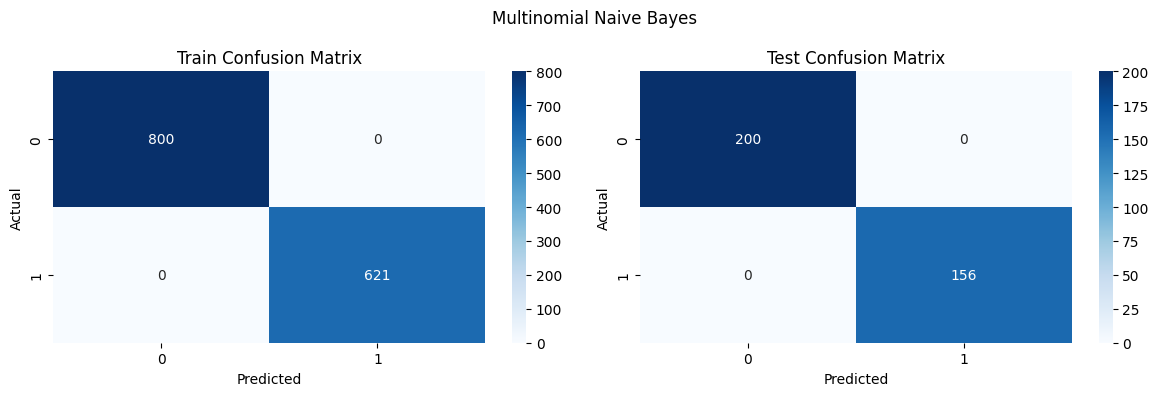


Train classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00       621

    accuracy                           1.00      1421
   macro avg       1.00      1.00      1.00      1421
weighted avg       1.00      1.00      1.00      1421

Test classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       156

    accuracy                           1.00       356
   macro avg       1.00      1.00      1.00       356
weighted avg       1.00      1.00      1.00       356



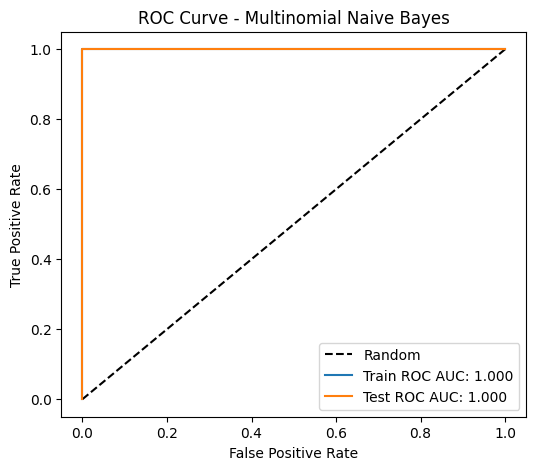


=== Random Forest Evaluation ===
Accuracy - Train: 1.0000 | Test: 1.0000
ROC AUC  - Train: 1.0000 | Test: 1.0000


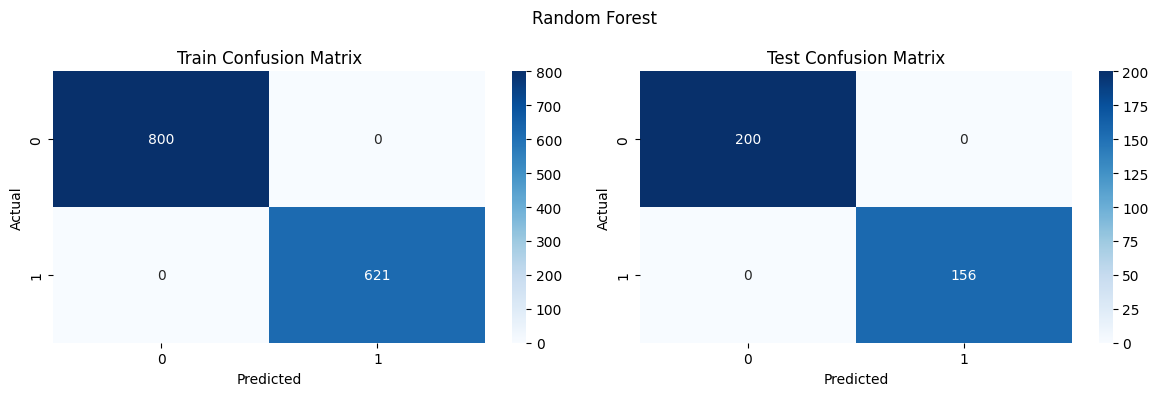


Train classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00       621

    accuracy                           1.00      1421
   macro avg       1.00      1.00      1.00      1421
weighted avg       1.00      1.00      1.00      1421

Test classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       156

    accuracy                           1.00       356
   macro avg       1.00      1.00      1.00       356
weighted avg       1.00      1.00      1.00       356



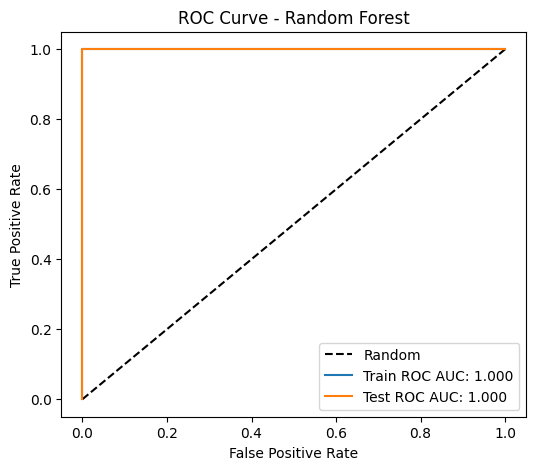

In [25]:
# Evaluate Naive Bayes and Random Forest
evaluate_model(fitted_models['MultinomialNB'], X_train, X_test, y_train, y_test, title="Multinomial Naive Bayes")
evaluate_model(fitted_models['RandomForest'], X_train, X_test, y_train, y_test, title="Random Forest")


In [26]:
# 6. Final pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

final_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000, preprocessor=lambda x: preprocess_text(x))),
    ('classifier', MultinomialNB())
])

final_pipeline.fit(df['message'], df['label_num'])

# Evaluate pipeline
X_test_raw = df.loc[idx_test, 'message']
y_test_raw = df.loc[idx_test, 'label_num']
y_pred_test_pipeline = final_pipeline.predict(X_test_raw)

print("Pipeline test accuracy:", accuracy_score(y_test_raw, y_pred_test_pipeline))
print("Pipeline classification report:\n", classification_report(y_test_raw, y_pred_test_pipeline))


Pipeline test accuracy: 1.0
Pipeline classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       156

    accuracy                           1.00       356
   macro avg       1.00      1.00      1.00       356
weighted avg       1.00      1.00      1.00       356



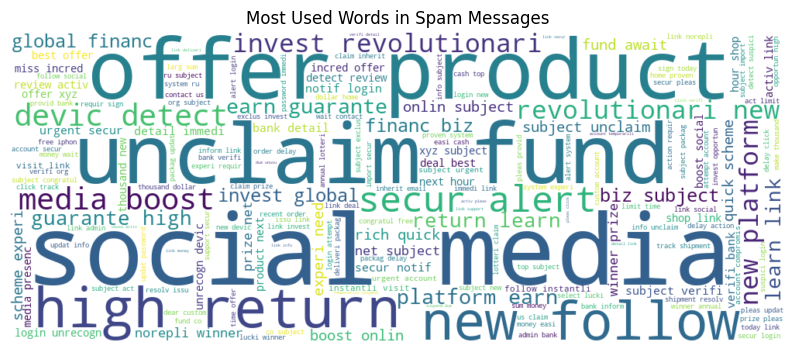

In [28]:
# 7. WordCloud for spam messages
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

spam_text = " ".join(df[df['label_num'] == 1]['message'].astype(str).str.lower().tolist())
stopwords_wc = set(STOPWORDS)
wordcloud = WordCloud(width=1000, height=400, background_color='white',
                      stopwords=stopwords_wc, max_words=200).generate(preprocess_text(spam_text))

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Used Words in Spam Messages")
plt.show()


In [30]:
import pickle

# Define safe preprocessor function
def text_preprocessor(x):
    return preprocess_text(x)

# Rebuild pipeline with named function
final_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000, preprocessor=text_preprocessor)),
    ('classifier', MultinomialNB())
])

# Train pipeline
final_pipeline.fit(df['message'], df['label_num'])

# Save to pickle
MODEL_FILENAME = "spam_classifier_pipeline.pkl"
with open(MODEL_FILENAME, "wb") as f:
    pickle.dump(final_pipeline, f)

print(f"Saved trained pipeline to {MODEL_FILENAME}")


Saved trained pipeline to spam_classifier_pipeline.pkl


In [31]:
# 9. Predict function
def load_pipeline(path="spam_classifier_pipeline.pkl"):
    with open(path, "rb") as fh:
        return pickle.load(fh)

def detect_spam(email_text: str, pipeline_obj=None) -> str:
    if pipeline_obj is None:
        pipeline_obj = load_pipeline(MODEL_FILENAME)
    pred = pipeline_obj.predict([email_text])[0]
    return "This is a Spam Email!" if int(pred) == 1 else "This is a Ham Email!"

# Examples
print(detect_spam("Congratulations! You've won a free iPhone. Claim now!"))
print(detect_spam("Hi friend, let's meet tomorrow for lunch."))


This is a Spam Email!
This is a Ham Email!


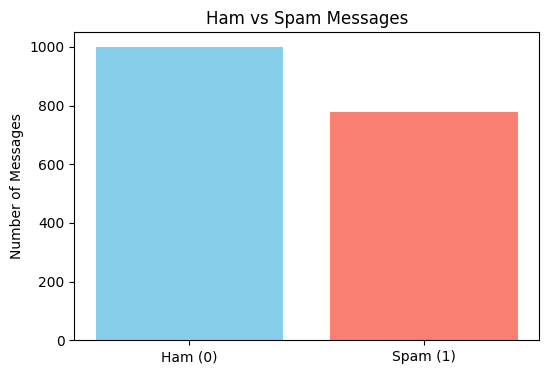

In [32]:
import matplotlib.pyplot as plt

# Count ham vs spam
label_counts = df['label_num'].value_counts().sort_index()

# 0 = ham, 1 = spam
plt.figure(figsize=(6,4))
plt.bar(['Ham (0)', 'Spam (1)'], label_counts, color=['skyblue', 'salmon'])
plt.title("Ham vs Spam Messages")
plt.ylabel("Number of Messages")
plt.show()


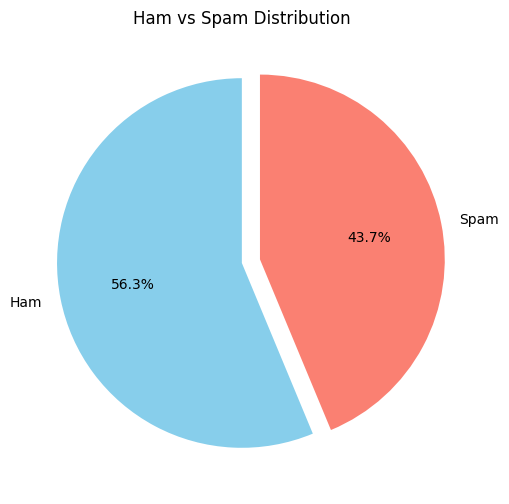

In [33]:
# Pie chart for ham vs spam
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=['Ham', 'Spam'], autopct='%1.1f%%',
        colors=['skyblue', 'salmon'], startangle=90, explode=(0,0.1))
plt.title("Ham vs Spam Distribution")
plt.show()
